In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.stats import pearsonr

%matplotlib inline

In [2]:
os.chdir('..')

### loading the validation (seen) data

In [3]:
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')
X_val.shape, y_val.shape

((19125, 32, 32, 32, 1), (19125, 32, 32, 32, 1))

### loading the unseen data

In [4]:
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')
X_test.shape, y_test.shape

((22500, 32, 32, 32, 1), (22500, 32, 32, 32, 1))

In [5]:
%time

# loading the model
resnet_model = load_model('models/resnet/050324_90p_samp_augment.hdf5')

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.48 µs


2024-03-06 15:47:37.936933: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 15:47:42.329426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


### Generating predictions

In [6]:
test_predictions = resnet_model.predict(X_test)
test_predictions.shape

2024-03-06 15:47:50.250107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


(22500, 32, 32, 32, 1)

In [7]:
val_predictions = resnet_model.predict(X_val)
val_predictions.shape

(19125, 32, 32, 32, 1)

### Sample & prediction plots

In [8]:
Ngrid=32

In [10]:
vmin = min(np.min(test_predictions), np.min(X_test))
vmax = max(np.max(test_predictions), np.max(X_test))

vmin, vmax

(-6.37655171866268, 15.024897)

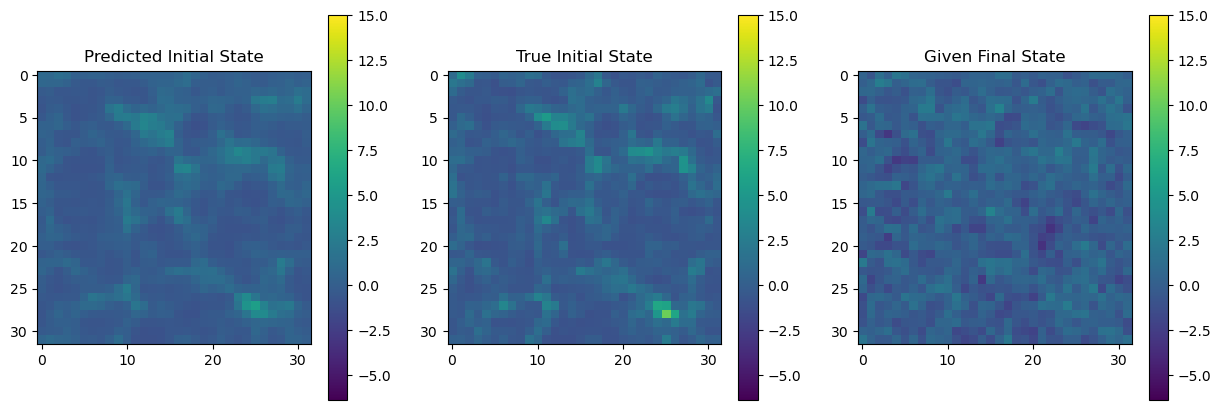

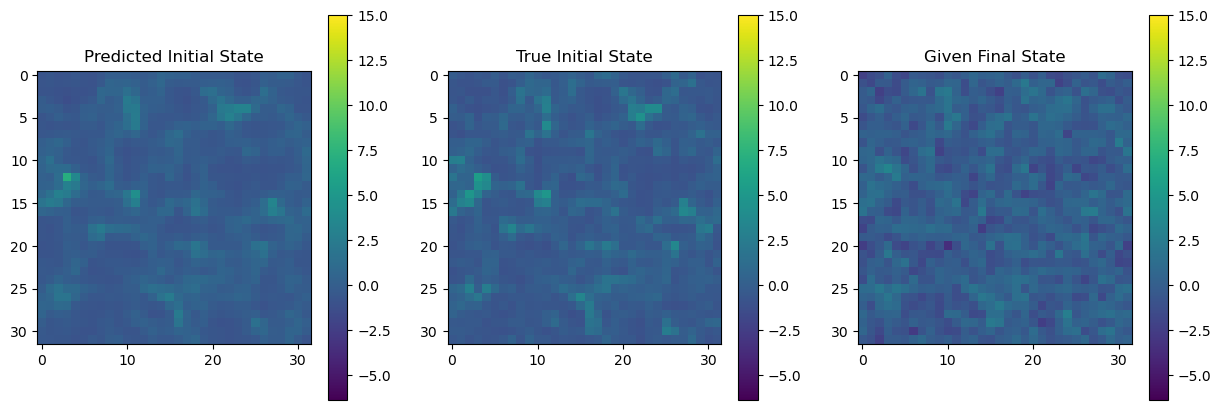

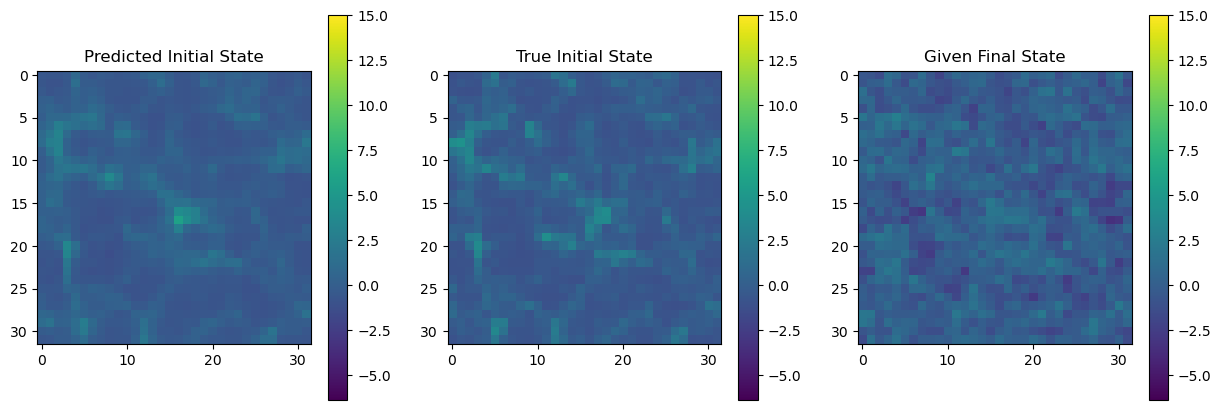

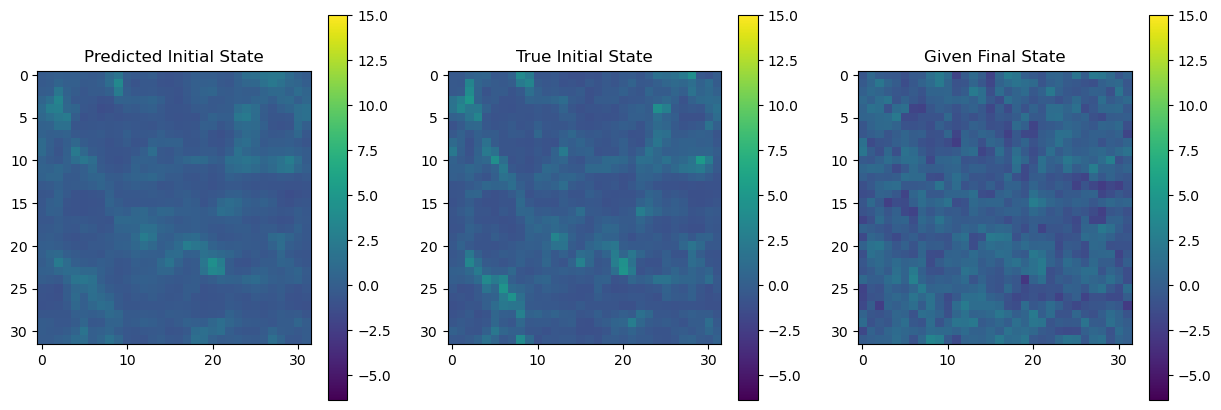

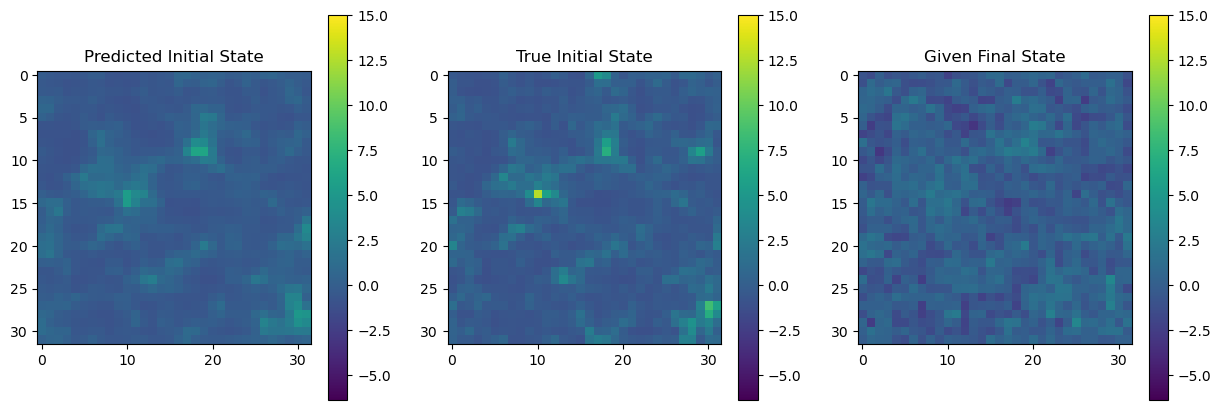

In [13]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # predicted initial state
    im = axs[0].imshow(test_predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # True final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax, 
                       cmap='viridis')
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [14]:
#error metrics
mse = mean_squared_error(y_test.flatten(), test_predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.38206111612525745
Mean Absolute Error (MAE): 0.41394906454180835


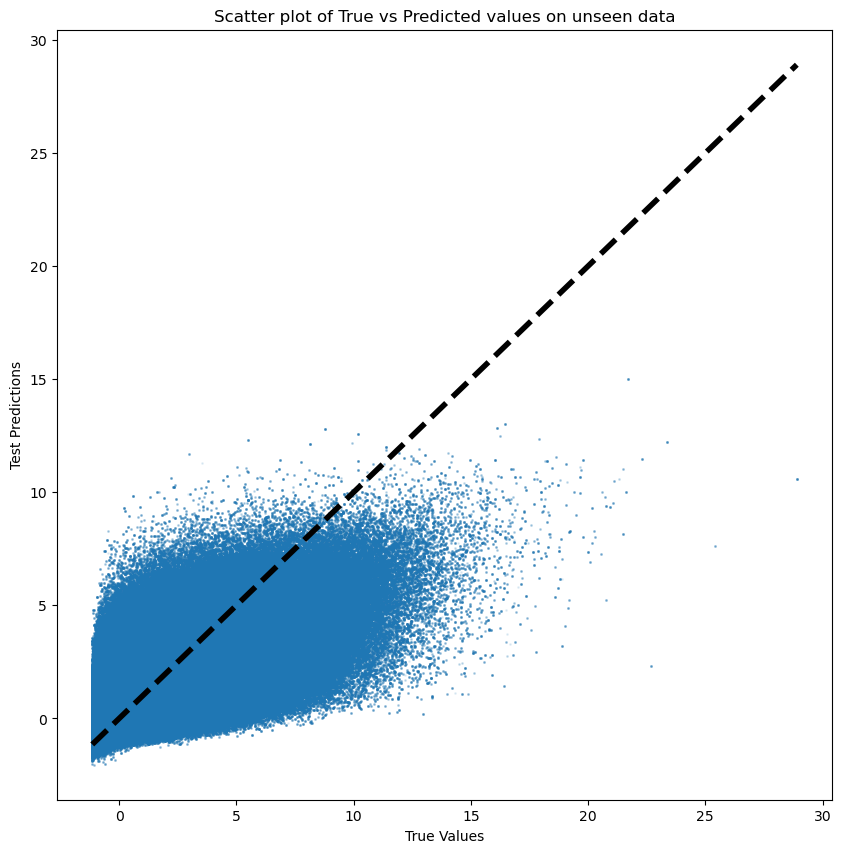

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), test_predictions.flatten(), alpha=0.1, s=1) # reduced marker size for easy plotting
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Test Predictions')
plt.title('Scatter plot of True vs Predicted values on unseen data')
plt.show()

In [16]:
val_mae = mean_absolute_error(y_val.flatten(), val_predictions.flatten())
val_mse = mean_squared_error(y_val.flatten(), val_predictions.flatten())
val_r2 = r2_score(y_val.flatten(), val_predictions.flatten())
val_pearson_corr, _ = pearsonr(y_val.flatten(), val_predictions.flatten())

test_mae = mean_absolute_error(y_test.flatten(), test_predictions.flatten())
test_mse = mean_squared_error(y_test.flatten(), test_predictions.flatten())
test_r2 = r2_score(y_test.flatten(), test_predictions.flatten())
test_pearson_corr, _ = pearsonr(y_test.flatten(), test_predictions.flatten())

# display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'R-squared', 'Pearson Correlation Coefficient'],
    'Validation Set': [val_mae, val_mse, val_r2, val_pearson_corr],
    'Test Set': [test_mae, test_mse, test_r2, test_pearson_corr]
})

metrics_df

,Metric,Validation Set,Test Set
0,Mean Absolute Error,0.413865,0.413949
1,Mean Squared Error,0.381948,0.382061
2,R-squared,0.618050,0.618017
3,Pearson Correlation Coefficient,0.786171,0.786150


# Script complete